<a href="https://colab.research.google.com/github/seokhee516/Project2-Credit-Scoring-System/blob/main/%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 문제정의

이번 프로젝트 주제는 "**씬파일러를 위한 신용평가 예측모형**" 입니다.
씬파일러(Thin filer)란, 금융 거래가 적거나 없어 관련 서류가 얇은 금융고객을 의미합니다. 주로 사회초년생, 주부, 은퇴자들이 이에 속해 있으며, 이들은 중저신용등급으로 책정되어 제도권 금융을 이용할 기회가 줄어들게 됩니다. 이처럼 금융이력이 부족한 이들의 채무불이행을 예측하고, 더 나아가 신파일러들의 금융 불이익을 해소 할 수 있는 신용평가를 제공하는 것이 이번 프로젝트의 목적입니다.

프로젝트에 사용할 데이터는 "**Lending Club(렌딩 클럽)**" 데이터입니다.
렌딩 클럽은 미국 유명 **P2P 대출 업체**로서, 신용등급이 낮아 제도권 금융기관에서 대출을 받을 수 없는 **씬파일러에게 훌륭한 대안금융 역할**을 하고 있습니다. 캐글에서 제공하고 있는 'Lending Club 2007-2020Q3' 데이터세트의 2018년부터 2020년 3분기 데이터를 활용하여 본 프로젝트를 진행하겠습니다.

렌딩 클럽 데이터는 대출상태(loan_status)를 상환, 유지, 연체, 회수불능 등 8개로 분류하였습니다. 이를 정상(상환, 유지)과 불량(연체, 회수불능)으로 이진 분류 문제를 풀어내겠습니다.

# 2. EDA 및 데이터 전처리

## 2.1 데이터 및 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import randint, uniform

from sklearn.model_selection import RandomizedSearchCV
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Categorical, Continuous
from sklearn_genetic.callbacks import DeltaThreshold, TimerStopping
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold


from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Project2-Credit-Scoring-System/LendingClub_Loan_status_2018-2020Q3.csv').iloc[:,1:]

## 2.2 EDA 및 데이터 전처리

In [3]:
# 19년 ~ 20년 데이터 사용
sepc = df['issue_d']>='Sep-2019'
octc = (df['issue_d']>='Oct-2019') & (df['issue_d']<='Oct-2020')
novc = (df['issue_d']>='Nov-2019') & (df['issue_d']<='Nov-2020')
mayc = (df['issue_d']>='May-2019') & (df['issue_d']<='May-2020')
df = df[sepc | octc | novc | mayc].reset_index().iloc[:,2:]

In [4]:
# loan_status 변수를 정상(0)과 불량(1)으로 이진 분류하여 Target 변수 생성
df.loc[(df['loan_status']== 'Fully Paid')|(df['loan_status']== 'Current'),"Target"]= 0 # 정상(0)
df.loc[(df['loan_status']== 'Late (31-120 days)')|(df['loan_status']== 'Charged Off')|
       (df['loan_status']== 'In Grace Period')|(df['loan_status']== 'Late (16-30 days)')|
       (df['loan_status']== 'Default')|(df['loan_status']== 'Issued')|
       (df['loan_status']== 'Late (31-120 days)'),'Target'] = 1 # 불량(1)

In [5]:
# 141 특성 중 29개만 사용
columns = ['annual_inc', 'inq_last_6mths', 'home_ownership','purpose', 'last_fico_range_high', 'last_fico_range_low',
           'sub_grade', 'int_rate', 'installment','tot_cur_bal', 'avg_cur_bal', 
           'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
           'mort_acc', 'num_il_tl', 'emp_length', 'num_tl_op_past_12m', 'revol_bal',
           'total_bc_limit', 'dti', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
           'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'tot_hi_cred_lim',
           'Target', 'issue_d'] # id, Target, issue_d: Date
df = df[columns]
df = df.dropna()

In [6]:
df.reset_index(inplace=True)
df.rename(columns = {'index':'id'},inplace=True)

In [7]:
# test set 만들기
test = df[(df['issue_d'] == 'Sep-2020') | (df['issue_d'] == 'May-2020')]
train = df.drop(test.index)

# validation set 만들기
train, val = train_test_split(train, train_size = 0.8, stratify=train['Target'], random_state=10)

In [8]:
def engineer(df):
    df = df.copy()

    # emp_length 범주형 변수 차원 증가 방지를 위해 범주군으로 묶음
    df.loc[(df['emp_length']== '< 1 year')|(df['emp_length']== '1 year')|
           (df['emp_length']== '2 years')|(df['emp_length']== '3 years'),'emp_length'] = 'less than 3 years'
    df.loc[(df['emp_length']== '4 years')|(df['emp_length']== '5 years')|
           (df['emp_length']== '6 years')|(df['emp_length']== '7 years')|
           (df['emp_length']== '8 years')|(df['emp_length']== '9 years'),'emp_length'] = 'more than 4 years and less than 9 years'
    df['emp_length'].fillna('unemployed', inplace=True)

    # purpose 범주형 변수 차원 증가 방지를 위해 범주군으로 묶음
    df.loc[(df['purpose']== 'car')|(df['purpose']== 'home_improvement')|
           (df['purpose']== 'house')|(df['purpose']== 'major_purchase')|
       (df['purpose']== 'medical')|(df['purpose']== 'moving')|
       (df['purpose']== 'other')|(df['purpose']== 'renewable_energy')|
       (df['purpose']== 'small_business')|(df['purpose']== 'vacation')|(df['purpose']== 'wedding'),'purpose'] = 'General loan debt'
    # int_rate % 기호를 제거하고 수치형으로 변환
    df['int_rate'] = df['int_rate'].replace('%','', regex=True).apply(pd.to_numeric)

    # sub_grade 수치형으로 변환
    sub_grade_ranks = {'A1': 1.1, 'A2': 1.2, 'A3': 1.3, 'A4': 1.4, 'A5': 1.5, 
                       'B1': 2.1, 'B2': 2.2, 'B3': 2.3, 'B4': 2.4, 'B5': 2.5, 
                       'C1': 3.1, 'C2': 3.2, 'C3': 3.3, 'C4': 3.4, 'C5': 3.5, 
                       'D1': 4.1, 'D2': 4.2, 'D3': 4.3, 'D4': 4.4, 'D5': 4.5}
    df['sub_grade'] = df['sub_grade'].map(sub_grade_ranks)


    # Reset index
    df = df.reset_index(drop=True)

    return df
train = engineer(train)
val = engineer(val)
test = engineer(test)

In [9]:
train_profile = train.profile_report()
train_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
features = train.drop(columns=['Target']).columns

X_train = train[features]
y_train = train['Target']
X_val = val[features]
y_val = val['Target']
X_test = test[features]
y_test = test['Target']

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

In [ ]:
# test ids를 저장하고 SHAP분석시 사용
test_id = X_test['id']

# 3. 모델링

In [ ]:
# 평가지표 함수
def model_evaluation(label, predict):
    cf_matrix = confusion_matrix(label, predict)
    Accuracy = (cf_matrix[0][0] + cf_matrix[1][1]) / sum(sum(cf_matrix))
    Precision = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[0][1])
    Recall = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[1][0])
    F1_Score = (2 * Recall * Precision) / (Recall + Precision)
    print("Model_Evaluation with Label: 1")
    print("Accuracy: {:.1%}".format(Accuracy))
    print("Precision: {:.1%}".format(Precision))
    print("Recall: {:.1%}".format(Recall))
    print("F1-Score: {:.1%}".format(F1_Score))

## 3.1 기준모델

In [ ]:
# Baseline
# 기준모델 검증세트
major = y_train.mode()[0]
y_val = val['Target']
y_val_pred = [major] * len(y_val)
print("기준모델 검증세트 평가")
model_evaluation(y_val, y_val_pred)

In [ ]:
y_test = test['Target']
y_test_pred = [major] * len(y_test)
print("기준모델 테스트세트 평가")
model_evaluation(y_test, y_test_pred)

In [ ]:
# 클래스 불균형
sns.countplot(x=pd.Series(y_train))

## 3.2 클래스 불균형 조절

In [ ]:
# weight를 이용한 클래스 조정
vc = y_train.value_counts().to_list()
ratio = float(vc[0]/vc[1])

In [ ]:
# SMOTE를 이용한 Oversampling 후 모델링
processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)
X_test_processed = processor.transform(X_test)

print("OverSampling 전, '불량(1)' 라벨의 수: {}".format(sum(y_train == 1)))
print("OverSampling 전, '정상(0)' 라벨의 수: {}\n".format(sum(y_train == 0)))
sm = SMOTE(random_state = 10, sampling_strategy=0.5)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train.ravel())
print("OverSampling 후, '불량(1)' 라벨의 수: {}".format(sum(y_train_res == 1)))
print("OverSampling 후, '정상(0)' 라벨의 수: {}".format(sum(y_train_res == 0)))

In [ ]:
# X_val과 X_test도 Oversampling 진행
X_val_res, y_val_res = sm.fit_resample(X_val_processed, y_val.ravel())
X_test_res, y_test_res = sm.fit_resample(X_test_processed, y_test.ravel())

## 3.3 Logistic Regression


In [ ]:
# Logistic Regression
lr_pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(random_state=10, n_jobs=-1,
                       class_weight='balanced',
                       max_iter=1000, solver='saga', penalty = 'l1')
)
lr_pipe.fit(X_train, y_train);
y_pred_lr_pipe = lr_pipe.predict(X_val)
print("로지스틱 검증세트 평가")
model_evaluation(y_val, y_pred_lr_pipe)
y_test_pred_lr_pipe = lr_pipe.predict(X_test)
print("로지스틱 테스트세트 평가")
model_evaluation(y_test, y_test_pred_lr_pipe)

In [ ]:
# Logistic Regression Oversampling
lr_pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(random_state=10, n_jobs=-1,
                       class_weight='balanced',
                       max_iter=1000)
)
lr_pipe.fit(X_train_res, y_train_res);
y_res_pred_lr_pipe = lr_pipe.predict(X_val_res)
print("로지스틱 검증세트 평가")
model_evaluation(y_val_res, y_res_pred_lr_pipe)

In [ ]:
y_test_res_pred_lr_pipe = lr_pipe.predict(X_test_res)
print("로지스틱 테스트세트 평가")
model_evaluation(y_test_res, y_test_res_pred_lr_pipe)

## 3.3 DecisionTree

In [ ]:
# DecisionTreeClassifier
dt_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=10, 
                           class_weight='balanced')
)
param_distributions = { 
    'decisiontreeclassifier__max_depth': [5, 7, 9, 12, 15], 
    'decisiontreeclassifier__min_samples_leaf': randint(2, 20),
    'decisiontreeclassifier__min_samples_split': randint(2, 20) 
}

search = RandomizedSearchCV(
    dt_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train, y_train);
dt_model = search.best_estimator_
y_pred_dt = dt_model.predict(X_val)
print("결정트리 검증세트 평가")
model_evaluation(y_val,y_pred_dt)

y_pred_dt_test = dt_model.predict(X_test)
print("결정트리 테스트세트 평가")
model_evaluation(y_test,y_pred_dt_test)

In [ ]:
# DecisionTreeClassifier Oversampling
dt_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=10, 
                           class_weight='balanced')
)
param_distributions = { 
    'decisiontreeclassifier__max_depth': [5, 7, 9, 12, 15], 
    'decisiontreeclassifier__min_samples_leaf': randint(2, 20),
    'decisiontreeclassifier__min_samples_split': randint(2, 20) 
}

search = RandomizedSearchCV(
    dt_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train_res, y_train_res);
dt_model2 = search.best_estimator_

y_pred_dt_res = dt_model2.predict(X_val_res)
print("결정트리 검증세트 평가")
model_evaluation(y_val_res,y_pred_dt_res)

y_pred_dt_test_res = dt_model2.predict(X_test_res)
print("결정트리 테스트세트 평가")
model_evaluation(y_test_res,y_pred_dt_test_res)

## 3.5 RandomForest

In [ ]:
# RandomForestClassifier
rf_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, n_jobs=-1,
                           class_weight='balanced')
)
param_distributions = { 
    'randomforestclassifier__n_estimators': randint(50, 800), 
    'randomforestclassifier__max_depth': [5, 7, 9, 12, 15], 
    'randomforestclassifier__min_samples_leaf': randint(2, 20),
    'randomforestclassifier__min_samples_split': randint(2, 20) 
}

search = RandomizedSearchCV(
    rf_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train, y_train);
rf_model = search.best_estimator_

y_pred_rf = rf_model.predict(X_val)
print("랜덤포레스트 검증세트 평가")
model_evaluation(y_val,y_pred_rf)

y_pred_rf_test = rf_model.predict(X_test)
print("랜덤포레스트 테스트세트 평가")
model_evaluation(y_test,y_pred_rf_test)

In [ ]:
# RandomForestClassifier Oversampling
rf_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, n_jobs=-1,
                           class_weight='balanced')
)
param_distributions = { 
    'randomforestclassifier__n_estimators': randint(50, 800), 
    'randomforestclassifier__max_depth': [5, 7, 9, 12, 15], 
    'randomforestclassifier__min_samples_leaf': randint(2, 20),
    'randomforestclassifier__min_samples_split': randint(2, 20) 
}

search = RandomizedSearchCV(
    rf_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train_res, y_train_res);
rf_model2 = search.best_estimator_

y_pred_rf_res = rf_model2.predict(X_val_res)
print("랜덤포레스트 검증세트 평가")
model_evaluation(y_val_res,y_pred_rf_res)

y_pred_rf_test_res = rf_model2.predict(X_test_res)
print("랜덤포레스트 테스트세트 평가")
model_evaluation(y_test_res, y_pred_rf_test_res)

## 3.6 XGBoost

In [ ]:
## XGBClassifier
xgb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=10, n_jobs=-1, silent=1,
                   class_weight='balanced')
)
param_distributions = { 
    'xgbclassifier__n_estimators': randint(50, 1000), 
    'xgbclassifier__max_depth': [5, 6, 7, 8, 9, 10], 
    'xgbclassifier__ min_child_weight ': randint(1, 10)
}

search = RandomizedSearchCV(
    xgb_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train, y_train);

xgb_model = search.best_estimator_
y_pred_xgb = xgb_model.predict(X_val)
print("XGB 검증세트 평가")
model_evaluation(y_val,y_pred_xgb)

y_pred_xgb_test = xgb_model.predict(X_test)
print("XGB 테스트세트 평가")
model_evaluation(y_test,y_pred_xgb_test)

In [ ]:
## XGBClassifier Oversamplig
xgb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=10, n_jobs=-1, silent=1,
                   class_weight='balanced')
)
param_distributions = { 
    'xgbclassifier__n_estimators': randint(50, 1000), 
    'xgbclassifier__max_depth': [5, 6, 7, 8, 9, 10], 
    'xgbclassifier__ min_child_weight ': randint(1, 10),
    'xgbclassifier__booster' : ["gbtree’", "dart", "gblinear"]
}

search = RandomizedSearchCV(
    xgb_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train_res, y_train_res);
xgb_model2 = search.best_estimator_

y_pred_xgb2_res = xgb_model2.predict(X_val_res)
print("XGB 검증세트 평가")
model_evaluation(y_val_res,y_pred_xgb2_res)

y_pred_xgb2_test_res = xgb_model2.predict(X_test_res)
print("XGB 테스트세트 평가")
model_evaluation(y_test_res,y_pred_xgb2_test_res)

## 3.7 LightGBM


In [ ]:
## LGBMClassifier
lgb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    LGBMClassifier(random_state=42, n_jobs=-1,
                   class_weight='balanced')
)
param_distributions = { 
    'lgbmclassifier__n_estimators': randint(50, 1000), 
    'lgbmclassifier__max_depth': [5, 7, 10, 12, 15], 
    'lgbmclassifier__num_leaves': randint(31, 100),
    'lgbmclassifier__boosting_type' : ["gbdt’", "dart", "rf"]
}

search = RandomizedSearchCV(
    lgb_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train, y_train);
lgb_model = search.best_estimator_
y_pred_lgb = lgb_model.predict(X_val)

print("LGBM 검증세트 평가")
model_evaluation(y_val,y_pred_lgb)

y_pred_lgb_test = lgb_model.predict(X_test)
print("LGBM 테스트세트 평가")
model_evaluation(y_test,y_pred_lgb_test)

In [ ]:
## LGBMClassifier Oversamplig
lgb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    LGBMClassifier(random_state=42, n_jobs=-1,
                   class_weight='balanced')
)
param_distributions = { 
    'lgbmclassifier__n_estimators': randint(50, 1000), 
    'lgbmclassifier__max_depth': [5, 7, 10, 12, 15], 
    'lgbmclassifier__num_leaves': randint(31, 100),
    'lgbmclassifier__boosting_type' : ["gbdt’", "dart", "rf"]
}

search = RandomizedSearchCV(
    lgb_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train_res, y_train_res);

lgb_model2 = search.best_estimator_
y_pred_lgb_res = lgb_model2.predict(X_val_res)
print("LGBM 검증세트 평가")
model_evaluation(y_val_res,y_pred_lgb_res)

y_pred_lgb_test_res = lgb_model2.predict(X_test_res)
print("LGBM 테스트세트 평가")
model_evaluation(y_test_res,y_pred_lgb_test_res)

## 3.8 CatBoost

In [ ]:
## CatBoostClassifier
cb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    CatBoostClassifier(random_state=10)
)
param_distributions = { 
    'catboostclassifier__n_estimators': randint(50, 1000), 
    'catboostclassifier__max_depth': [5, 7, 10, 12, 15], 
    'catboostclassifier__num_leaves': randint(31, 100)
}

search = RandomizedSearchCV(
    cb_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train, y_train);

cb_model = search.best_estimator_
y_pred_cb = cb_model.predict(X_val)
print("CatBoost 검증세트 평가")
model_evaluation(y_val,y_pred_cb)
y_pred_cb_test = cb_model.predict(X_test)
print("CatBoost 테스트세트 평가")
model_evaluation(y_test,y_pred_cb_test)

In [ ]:
## CatBoostClassifier Oversamplig
cb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    CatBoostClassifier(random_state=10)
)
param_distributions = { 
    'catboostclassifier__n_estimators': randint(50, 1000), 
    'catboostclassifier__max_depth': [5, 7, 10, 12, 15], 
    'catboostclassifier__num_leaves': randint(31, 100)
}

search = RandomizedSearchCV(
    cb_pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=10
)
search.fit(X_train_res, y_train_res);

cb_model2 = search.best_estimator_
y_pred_cb_res = cb_model2.predict(X_val_res)
print("CatBoost 검증세트 평가")
model_evaluation(y_val_res,y_pred_cb_res)

y_pred_cb_test_res = cb_model2.predict(X_test_res)
print("CatBoost 테스트세트 평가")
model_evaluation(y_test_res,y_pred_cb_test_res)

## 3.8 모델링 결과 정리

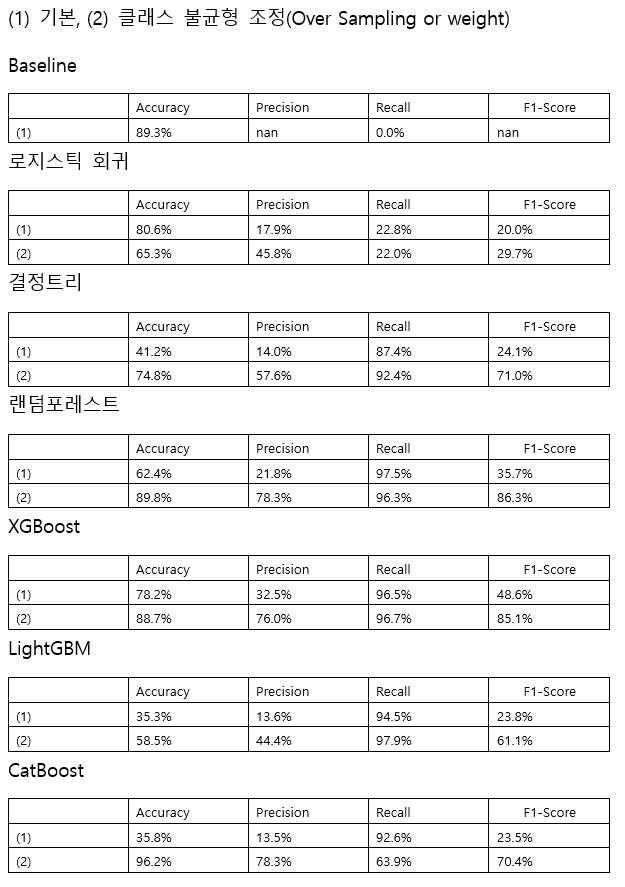

# 4. 결과해석

## 대출을 상환하지 못한 고객의 특징은 무엇일까?

In [ ]:
class_index = 1
y_pred_proba= xgb_model.predict_proba(X_test)[:, class_index]

In [ ]:
df_p = pd.DataFrame({
    'id': test_id, 
    'pred_proba': y_pred_proba, # 예측확률 
    'Target': y_test # 실제값
})

df_p = df_p.merge(
     df[['id', 'issue_d', 'annual_inc', 'inq_last_6mths', 'sub_grade', 'int_rate',
       'installment', 'tot_cur_bal', 'avg_cur_bal', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'num_il_tl',
       'emp_length', 'num_tl_op_past_12m', 'revol_bal', 'total_bc_limit',
       'dti', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'tot_hi_cred_lim', 'home_ownership', 'purpose', 'last_fico_range_high',
       'last_fico_range_low']],
     how='left'
)

In [ ]:
df_p.head()

In [ ]:
fully_paid = df_p['Target'] == 0
charged_off = ~fully_paid
right = (fully_paid) == (df_p['pred_proba'] > 0.50)
wrong = ~right

In [ ]:
# 대출을 상환하지 못한 샘플들
df_p[charged_off & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

In [ ]:
row = X_test.iloc[[6780]]
row

### SHAP

In [ ]:
explainer = shap.TreeExplainer(rf_model.named_steps['randomforestclassifier'])
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=row, 
    link='logit' 
)

In [ ]:
row_processed = processor.transform(X_test.iloc[:100])

shap.initjs()
shap_values = explainer.shap_values(row_processed)
shap.summary_plot(shap_values[1], row_processed, plot_type="bar")

- Feature 23 : tot_rec_int, 